# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
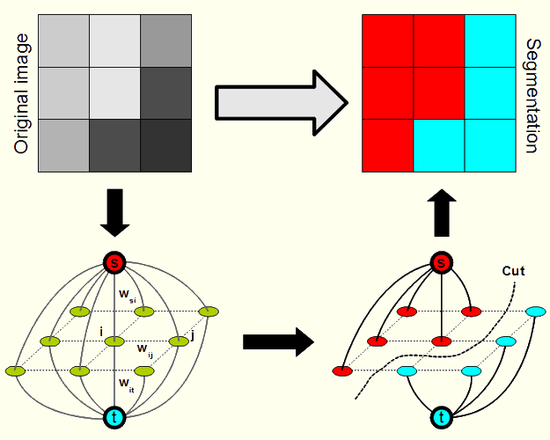

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
from collections import namedtuple
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import igraph as ig
import logging
import sys
from tqdm.auto import tqdm as tq

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.WARN)

In [3]:
con = namedtuple('_', ('FIX', 'UNK', 'FG', 'BG'))(1, 0, 1, 0)
NUM_GMM_COMP = 5
GAMMA = 50
LAMDA = 9 * GAMMA
NUM_ITERS = 3
TOL = 1e-3

In [4]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _types, _alphas, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._types = _types
        self._alphas = _alphas
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def types(self):
        return self._types

    @types.setter
    def types(self, _types):
        self._types = _types
    
    @property
    def alphas(self):
        return self._alphas

    @alphas.setter
    def alphas(self, _alphas):
        self._alphas = _alphas
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

                # initialise types and alphas
                temp = np.zeros(self._types.shape, dtype=np.uint8)
                rect = self.FLAGS['RECT']
                temp[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = 1
                self._types[temp == 0] = con.FIX
                self._alphas[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = con.FG

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == True:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._alphas, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._types, (x,y), 3, con.FIX, -1)

In [5]:
def run(filename, n_components=NUM_GMM_COMP, gamma=GAMMA, lamda=LAMDA,
        num_iters=NUM_ITERS, tol=TOL, connect_diag=True):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : con.BG}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : con.FG}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    types = np.zeros(img.shape[:2], dtype = np.uint8)  # whether a pixel is known or unknown
    alphas = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                       #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)             # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, types, alphas, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        types = EventObj.types
        alphas = EventObj.alphas
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            types = np.zeros(img.shape[:2], dtype = np.uint8) 
            alphas = np.zeros(img.shape[:2], dtype = np.uint8)
            EventObj.image = img
            EventObj.types = types
            EventObj.alphas = alphas
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            alphas = grab_cut(img2, types, alphas, n_components, gamma, lamda, num_iters, tol, connect_diag)
            EventObj.alphas = alphas

        
        EventObj.flags = FLAGS
        mask2 = np.where((alphas == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

# The GrabCut Algorithm

The grabcut algorithm addresses the problem of efficient, interactive extraction of a foreground object in a complex environment, whose background cannot be trivially subtracted. The result of the algorithm is an alpha-matte, a binary mask which denotes the foreground and background pixels. The algorithm steers clear of estimating transparency values because of the complexity of the problem, and uses a border-matting (edge-softening technique that we do not implement here.

The algorithm builds upon the GraphCut algorithm, iteratively applying the latter along with several other modifications. The algorithm boasts producing delightfully accurate mattes with minimal and very convenient user interaction.

The algorithm works as follows:
- The algorithm, at any point in time, maintains a set of pixels known to be either in the background ($T_B$) or in the foreground ($T_F$). The rest of the pixels, $T_U$ are unknown and are the ones whose $\alpha$ value is to be estimated.
- At any point in time, the algorithm maintains, for every pixel, an $\alpha$ value which indicates whether the pixel $p$ is in the foreground ($\alpha_p=1$) or in the background ($\alpha_p=0$). These are iteratively refined for pixels in $T_U$ and are fixed for the rest.
- Using all the foreground and background pixels (estimated and known) currently, the algorithm estimates two gaussian mixtures, one for the foreground and background respectively. These are used to estimate the *probability* of a pixel being in the background or in the foreground independent of all other pixels. The algorithm also considers the continuity or smoothness between these pixels - neighbouring pixels have a higher probability of having the same alpha label, except at the object boundary.
- The algorithm calculates a Gibbs Energy:  
$$\mathbf{E}(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) = U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) + V(\underline{\alpha}, \mathbf{z})$$  
where $\mathbf{k}$, $\underline{\theta}$, $\mathbf{z}$ refer to the GMM component assignments, the GMM parameters and the pixel values respectively.
- The data term, $U$, calculated as the negative log score of a pixel according the the GMM corresponding to its current $\alpha$ value, summed over all pives, deals with the individual likeness of a pixel to belong to the foreground or the background, while the smoothness term, $V$ deals with continuity between pairs of neighbouring pixels.
$$ V(\underline{\alpha}, \mathbf{z}) = \gamma \sum_{(m, n) \in neighbours}indicate(\alpha_n \neq \alpha_m) e^{-\beta||z_m - z_n||_{2}^{2}} $$
- The algorithm then tries to iteratively minimise this energy using the mincut of a graph, as in graphcut.
- The algorithm further allows the user to refine the results by marking pixels as foreground or background again, following which, the energy minimisation is rerun once using the last estimated GMMs. **Optionally, the algorithm allows the entire iterative minimisation to be repeated - which is what we implement here, preferring accuracy  over runtime.**

## Implementation Details
- We use eight-connectivity by default, calculating $\beta$ as the inverse of twice the average of $||z_m - z_n||_{2}^{2}$ over all edges in the graph (neighbouring pixels).
- The capacity of edges connecting known foreground pixels to the source and known background pixels to the sink is set to $9$ times the value of $\gamma$, ensuring that it is large enough (for both four- and eight- connectivity) for the edge to never get cut.
- We skip the indicator term from the smoothness energy, allowing all neighbouring pixels to be connected, irrespective of whether they are at the object boundary or not. This improves results by allowing pixels in the internal regions of the object to force neighbouring pixels towards itself.
- As stated above, we rerun the entire iterative optimisation again after user refinement (which is optional according to the original algorithm), favouring accuracy over runtime.
- By default, we use $\gamma=50$ and $3$ iterations of grabcut, with a tolerance of change for the mincut value.

In [6]:
def fit_gmms(img, alphas, n_components):
    fg = GaussianMixture(n_components=n_components)
    fg.fit(img[alphas == con.FG].reshape((-1, img.shape[-1])))

    bg = GaussianMixture(n_components=n_components)
    bg.fit(img[alphas == con.BG].reshape((-1, img.shape[-1])))

    return fg, bg

def graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda, connect_diag):
    logging.info('GRAPH CUT')
    
    # compute region energy in one go to speed up
    fg_D = - fg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    bg_D = - bg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])

    # closure function to calculate boundary energy
    def compute_V(i, j, oi, oj):
        diff = img[i, j] - img[oi, oj]
        return gamma * np.exp(- beta * diff.dot(diff))

    # fixed capacity for known edges
    fix_cap = lamda

    # BUILD GRAPH
    logging.info('BUILD GRAPH')
    num_pix = img.shape[0] * img.shape[1]

    def vid(i, j): # vertex ID
        return (img.shape[1] * i) + j

    def ind(idx): # image index
        return ((idx // img.shape[1]), (idx % img.shape[1]))
    
    graph = ig.Graph(directed=False)
    graph.add_vertices(num_pix + 2)
    S = num_pix
    T = num_pix+1
    # the last two vertices are S and T respectively

    edges = []
    weights = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            # add edges to S and T
            if types[i, j] == con.FIX:
                if alphas[i, j] == con.FG:
                    edges.append((vid(i, j), S))
                    weights.append(fix_cap)
                else:
                    edges.append((vid(i, j), T))
                    weights.append(fix_cap)
            else:
                edges.append((vid(i, j), S))
                weights.append(bg_D[i, j])

                edges.append((vid(i, j), T))
                weights.append(fg_D[i, j])
            
            # add edges to neighbours
            if i > 0:
                oi = i-1
                oj = j
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))
            
            if j > 0:
                oi = i
                oj = j-1 
                edges.append((vid(i, j), vid(oi, oj)))
                weights.append(compute_V(i, j, oi, oj))

            if connect_diag:
                if i > 0 and j > 0:
                    oi = i-1
                    oj = j-1 
                    edges.append((vid(i, j), vid(oi, oj)))
                    weights.append(compute_V(i, j, oi, oj))

                if i > 0 and j < img.shape[1] - 1:
                    oi = i-1
                    oj = j+1 
                    edges.append((vid(i, j), vid(oi, oj)))
                    weights.append(compute_V(i, j, oi, oj))
    
    graph.add_edges(edges, attributes={'weight': weights})
    logging.info('MINCUT')
    cut = graph.st_mincut(S, T, capacity='weight')
    bg_vertices = cut.partition[0]
    fg_vertices = cut.partition[1]
    if S in bg_vertices:
        bg_vertices, fg_vertices = fg_vertices, bg_vertices
    
    new_alphas = np.zeros(img.shape[:2], dtype=np.uint8) # con.BG is filled, zeroes is faster
    for v in fg_vertices:
        if v not in (S, T):
            new_alphas[ind(v)] = 1
    return cut.value, new_alphas


def grab_cut(img_, types_, alphas_, n_components, gamma, lamda,
             num_iters, tol, connect_diag):
    
    logging.debug('GRAB CUT')
    img = img_.copy().astype(np.float32)
    types = types_.copy() # types tells whether the pixel is fixed or unknown
    alphas = alphas_.copy() # alphas tells whether the pixel is fg or bg according to fixed or current estimate
    
    # calculate beta
    logging.info('CALC BETA')
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                diff = img[i, j] - img[i-1, j]
                beta += diff.dot(diff)
            if j > 0:
                diff = img[i, j] - img[i, j-1]
                beta += diff.dot(diff)
            if connect_diag:
                if i > 0 and j > 0:
                    diff = img[i, j] - img[i-1, j-1]
                    beta += diff.dot(diff)
                if i > 0 and j < img.shape[1] - 1:
                    diff = img[i, j] - img[i-1, j+1]
                    beta += diff.dot(diff)
    if connect_diag:
        beta /= (4 * img.shape[0] * img.shape[1] - 3 * img.shape[0] - 3 * img.shape[1] + 2)
    else:
        beta /= (2 * img.shape[0] * img.shape[1] - img.shape[0] - img.shape[1])
    beta *= 2
    beta = 1 / beta
    
    prev_flow = -1
    for _ in tq(range(num_iters)):
        fg_gmm, bg_gmm = fit_gmms(img, alphas, n_components)
        flow, alphas = graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda, connect_diag)
    
        if prev_flow != -1 and abs(prev_flow - flow) < tol:
            break
        
        prev_flow = flow
    
    logging.info('DONE')
    return alphas

In [17]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'              # Path to image file
    try:
        run(filename)
    finally:
        cv2.destroyAllWindows()

100%|██████████| 3/3 [01:06<00:00, 22.03s/it]


## Some Results

Here, we vary different parameters to see their effect on the performance of the algorithm qualitatively (due to the absence of ground truth segmentation masks required for any quantitative analysis), which, for this specific problem, easily gives a very good idea of the performance of the algorithm. It is evident from the start that the algorithm can handle some very challenging situations (such as noisy backgrounds and foregrounds) really well, even in just a few iterations and with imperfect user input.

**Run-1: ** Default parameters, no user refinement.  
<img src="../out/results-2.png" height=300/><img src="../out/results-1.png" height=300/>

**Run-2: ** Default parameters, with user refinement.  
<img src="../out/results-3.png" width=500/>  
<img src="../out/results-4.png" width=500/>  

This one is challenging because of the similarity in colours of the foreground and background pixels. The boundary (smoothness) term in the Gibbs Energy plays an important role here.

## Effect of Parameters and Variations

### Effect of $\gamma$
$\gamma$ weights the boundary edges against the region edges. A larger $\gamma$ makes it harder for boundary edges to be cut, placing more importance on continuity over the individual susceptibility of a pixel to belong to the foreground or background. Here, we run the algorithm with $\gamma$ set to $50$ on the higher side and $1$ on the lower side on the `llama.jpg` image.

In [9]:
filename = '../images/llama.jpg'
try:
    # run(filename, gamma=50)
    run(filename, gamma=1)
finally:
    cv2.destroyAllWindows()

100%|██████████| 3/3 [00:46<00:00, 15.56s/it]


**Run 1: ** $\gamma = 50$  
<img src="../out/gamma-1.png" width=500/>

**Run 2: ** $\gamma = 1$  
<img src="../out/gamma-2.png" width=500/>

Here, we notice that in the second run, a lot of the background which is *similarily coloured as the subject,* is labelled as the foreground. This is because by setting $\gamma=1$, we lower the weight of the boundary edges, letting them be easily cut. This places more importance on the individual resemblance of a pixel to the mainstream foreground and background colours - allowing parts of the background similarily coloured as the object to be classified as the foreground - even though they are discontinuously placed.

### Effect of four- and eight- connectivity

The graphcut algorithm which is at the heart of grabcut uses a graph model to represent connections between neighbouring pixels. The neighbourhood of a pixel can be defined as the four or pixels surrounding it, among other ways. Which method is used affects the strength of boundary relations - which play an important role in the tendency of the algorithm to categorise continuous regions similarly. The two-fold change in number of edges in the graph affects the time taken by the mincut algorithm to run as well. Here we run the algorithm with four- and eight- connectivity on `llama.jpg` with a reduced value of $\gamma$ to highten the visibility of the effect.

In [10]:
filename = '../images/llama.jpg'
try:
    run(filename, gamma=10, connect_diag=True)
    run(filename, gamma=10, connect_diag=False)
finally:
    cv2.destroyAllWindows()

100%|██████████| 3/3 [00:45<00:00, 15.11s/it]


**Run 1: Eight-Connectivity**  
<img src="../out/connect-1.png" width=500/>

**Run 2: Four-Connectivity**  
<img src="../out/connect-2.png" width=500/>

We again notice a tendency of regions of the background similar in colour to the object being categorised as the foreground. This is because a decrease in number of edges and connectivity of the graph places more weight on the region terms of the energy function, giving more importance to the colour (and hence likeness to the background and foreground colour models) of an individual pixel rather than its relation to the surrounding region. We also notice noisy and rough edges because of the same effect - each pixel's individual colour becomes more important. This is further visible in the segmentation of the image `elefant.jpg`.

In [11]:
filename = '../images/elefant.jpg'
try:
    run(filename, gamma=10, connect_diag=True)
    run(filename, gamma=10, connect_diag=False)
finally:
    cv2.destroyAllWindows()

100%|██████████| 3/3 [00:39<00:00, 13.26s/it]


**Run 1: Eight-Connectivity**  
<img src="../out/connect-3.png" width=500/>

**Run 2: Four-Connectivity**  
<img src="../out/connect-4.png" width=500/>

Notice the rough edges in the second case, with four-connectivity. This artifact arises because whether or not two diagonally adjacent pixels are categorised similarly has no affect on the energy and hence the segmentation - giving the edges a staircase-like look.

### Effect of Number of Components in the Gaussian Mixture Foreground and Background Models

We use two gaussian mixture models, one for the background and the other for the foreground. Each component in the model allows it to represent a different colour shade which could appear in the background or the foreground. The intent here is to have enough components to represent colours which form major sections of the background/foreground, such as the sky, grass and street in the background of a road scene, and the red body, blue windows and black tires of a car in the foreground. Small regions of a different colour need not be explicitly modelled by a gaussian mixture component, as they can be handled by the boundary terms alone. While increasing the number of components allows for the mixtures to model more diverse foregrounds and backgrounds, it could also lead to the two mixtures modelling components of the other because of imperfect $\alpha$s while initialising the models - leading to the foreground including parts of the background and vice versa. The time required to fit the mixture models also increases with an increase in number of components. Here we try gaussian mixtures with $5$ and $10$ components on an image with a diverse background, `person6.jpg`. The size of the bounding box is kept large to highten the difference. 

In [15]:
filename = '../images/person6.jpg'
try:
    run(filename, n_components=5)
    run(filename, n_components=10)
finally:
    cv2.destroyAllWindows()

100%|██████████| 3/3 [01:27<00:00, 29.16s/it]


**Run 1: Number of Components**  
<img src="../out/components-1.png" width=500/>

**Run 2: Number of Components**  
<img src="../out/components-2.png" width=500/>

While none of the segmentations is perfect, the second one has more of the background being classified as foreground - because of the foreground gaussian mixture modelling colours that are part of the actual background. The runtime difference is also noticeable, with each iteration taking a little less than twice the time on doubling the number of mixture components.

# Bonus: MRF for Image Denoising

In [27]:
SIGMA = 5
BETA = 1
N_MEAN = 0
N_VAR = 100

WEIGHTS = (0.2989, 0.5870, 0.1140) # weights for RGB
def grayscale(pixel, weights):
    return (pixel.astype(np.float64) @ np.array(weights))

def pot(i, j):
    return float(i - j)**2

def denoise(img, sigma=SIGMA, beta=BETA):
    height, width = img.shape
    for i in tq(range(height-1)):
        for j in tq(range(width-1)):
            xmin = 0
            min_ = 1e10

            for x in range(256):
                prob = float(((img[i, j]-x)**2)/(2.0*sigma) + beta * (pot(img[i, j-1],x) + pot(img[i, j+1],x) + pot(img[i-1, j], x) + pot(img[i+1, j], x)))
                
                if prob < min_:
                    min_ = prob
                    xmin = x
            
            img[i, j] = xmin
    
    return img.astype(np.uint8)

def add_noise(img, mean=N_MEAN, var=N_VAR):
    gauss = np.random.normal(mean, np.sqrt(var), img.shape)
    return img + gauss


In [28]:
filename = '../images/banana1-resize.jpg'
img = plt.imread(filename)
img = np.apply_along_axis(grayscale, 2, img, WEIGHTS)

noisy_img = add_noise(img)
clean_img = denoise(noisy_img)
fig, ax = plt.subplots(1, 3)



█▊       | 85/299 [00:00<00:00, 848.56it/s]
100%|██████████| 224/224 [01:23<00:00,  2.67it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

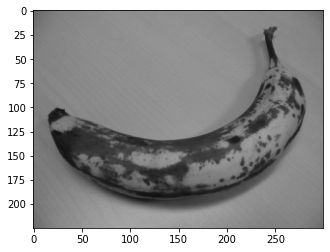

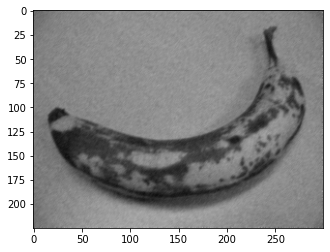

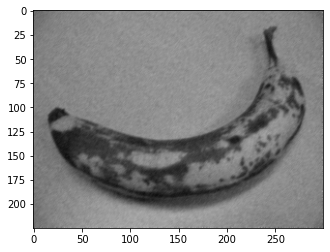

In [32]:
plt.imshow(img.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(noisy_img.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(clean_img, cmap='gray', vmin=0, vmax=255)
plt.show()